In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('./Data/MNIST.csv', index_col=0)

In [2]:
# Seperate Features and Labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [3]:
# Cast to numpy arrays
X = X.values
y = y.astype(int).values

In [4]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
X = ((X / 255.0) - 0.5) * 2

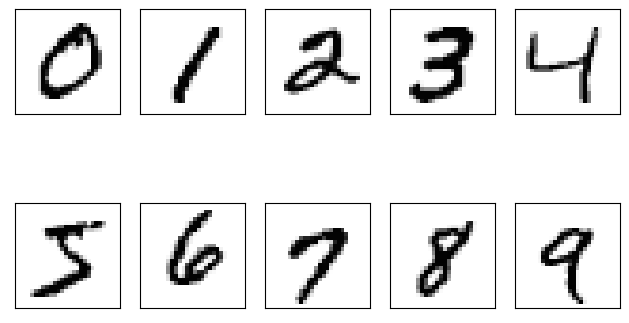

In [6]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True
)

ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

if 'Results' not in os.listdir():
    os.mkdir('Results')

plt.savefig('./Results/1_MNIST_Images.png')
plt.show()

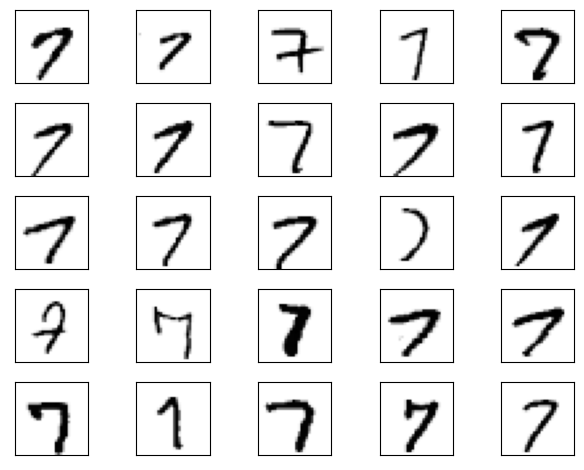

In [7]:
# Visualizing several examples of the same class
fig, ax = plt.subplots(
    nrows=5,
    ncols=5,
    sharex=True,
    sharey=True
)

ax = ax.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.savefig('./Results/2_MNIST_Images_Same_Class.png')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=10000,
    random_state=123,
    stratify=y
)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp,
    y_temp,
    test_size=5000,
    random_state=123,
    stratify=y_temp
)

In [10]:
print(f'Samples selected for training: {X_train.shape[0]}')
print(f'Samples selected for validation: {X_valid.shape[0]}')
print(f'Samples selected for testing: {X_test.shape[0]}')

Samples selected for training: 55000
Samples selected for validation: 5000
Samples selected for testing: 10000


In [14]:
from Algorithms import NeuralNetMLP, int_to_onehot, sigmoid

model = NeuralNetMLP(
    num_features=28*28,
    num_hidden=50,
    num_classes=10
)

In [12]:
# Minibatch Generator Function
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X: np.ndarray, y: np.ndarray, minibatch_size: int):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    iterator = range(0, indices.shape[0] - minibatch_size + 1, minibatch_size)

    for start_index in iterator:
        batch_index = indices[start_index:start_index + minibatch_size]
        yield X[batch_index], y[batch_index]

In [13]:
# Verifying minibatch function
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(
        X=X_train,
        y=y_train,
        minibatch_size=minibatch_size
    )
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

# X_train_mini should have 100 samples(Depending on chosen minibatch_size) with 784 features
# y_train_mini should have 100 class labels corresponding to
# the 100 samples of X_train_mini
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [15]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(
        targets,
        num_labels=num_labels
    )
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [16]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas=probas)
print(f'Initial Validation MSE: {mse:.1f}')

Initial Validation MSE: 0.3


In [17]:
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels=predicted_labels)
print(f'Initial Validation Accuracy: {acc*100:.1f}%')

Initial Validation Accuracy: 9.4%


In [20]:
def compute_mse_and_acc(nnet: NeuralNetMLP, X, y, num_labels=10, minibatch_size=100):
    
    mse, correct_pred, num_examples = 0.0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size=minibatch_size)
    
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(
            targets,
            num_labels=num_labels
        )
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    
    mse = mse/i

    acc = correct_pred/num_examples

    return mse, acc

In [21]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial Validation MSE: {mse:.1f}')
print(f'Initial Validation Accuracy: {acc*100:.1f}')

Initial Validation MSE: 0.3
Initial Validation Accuracy: 9.4


In [34]:
def train(
    model: NeuralNetMLP,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    num_epochs: int,
    learning_rate: float = 0.1
):
    epoch_loss: list = []
    epoch_train_acc: list = []
    epoch_valid_acc: list = []

    for e in range(num_epochs):
        # Iterate over mini-batches
        minibatch_gen = minibatch_generator(
            X_train,
            y_train,
            minibatch_size=minibatch_size
        )
        
        for X_train_mini, y_train_mini in minibatch_gen:
            
            # Compute Outputs
            a_h, a_out = model.forward(X_train_mini)

            # Compute Gradients
            (d_loss__d_w_out,
             d_loss__d_b_out,
             d_loss__d_w_h,
             d_loss__d_b_h
            ) = model.backward(
                X_train_mini,
                a_h,
                a_out,
                y_train_mini
            )

            # Update Weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        # Epoch Logs
        train_mse, train_acc = compute_mse_and_acc(
            model,
            X_train,
            y_train
        )

        valid_mse, valid_acc = compute_mse_and_acc(
            model,
            X_valid,
            y_valid
        )

        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d} / {num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f}'
              f'| Train Acc: {train_acc:.2f}'
              f'| Valid Acc: {valid_acc:.2f}'
        )
    
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [35]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    num_epochs=50,
)

Epoch: 001 / 050 | Train MSE: 0.05| Train Acc: 76.15| Valid Acc: 75.98
Epoch: 002 / 050 | Train MSE: 0.03| Train Acc: 85.45| Valid Acc: 85.04
Epoch: 003 / 050 | Train MSE: 0.02| Train Acc: 87.82| Valid Acc: 87.60
Epoch: 004 / 050 | Train MSE: 0.02| Train Acc: 89.36| Valid Acc: 89.28
Epoch: 005 / 050 | Train MSE: 0.02| Train Acc: 90.21| Valid Acc: 90.04
Epoch: 006 / 050 | Train MSE: 0.02| Train Acc: 90.67| Valid Acc: 90.54
Epoch: 007 / 050 | Train MSE: 0.02| Train Acc: 91.12| Valid Acc: 90.82
Epoch: 008 / 050 | Train MSE: 0.02| Train Acc: 91.43| Valid Acc: 91.26
Epoch: 009 / 050 | Train MSE: 0.01| Train Acc: 91.84| Valid Acc: 91.50
Epoch: 010 / 050 | Train MSE: 0.01| Train Acc: 92.04| Valid Acc: 91.84
Epoch: 011 / 050 | Train MSE: 0.01| Train Acc: 92.30| Valid Acc: 92.08
Epoch: 012 / 050 | Train MSE: 0.01| Train Acc: 92.51| Valid Acc: 92.24
Epoch: 013 / 050 | Train MSE: 0.01| Train Acc: 92.65| Valid Acc: 92.30
Epoch: 014 / 050 | Train MSE: 0.01| Train Acc: 92.80| Valid Acc: 92.60
Epoch:

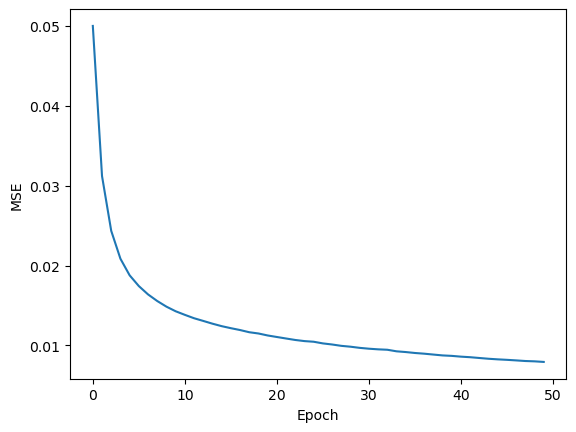

In [36]:
# Evaluating Neural Network Performance
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.savefig('./Results/3_NN_Performance.png')
plt.show()

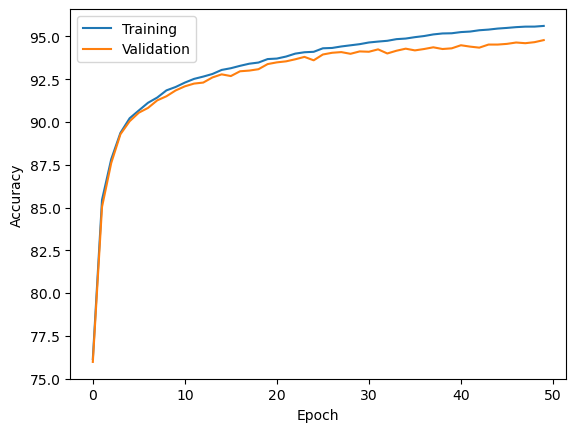

In [37]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('./Results/4_NN_Accuracy.png')
plt.show()

In [38]:
# Test Accuracy
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test Accuracy: {test_acc*100:.2f}%')

Test Accuracy: 94.54%


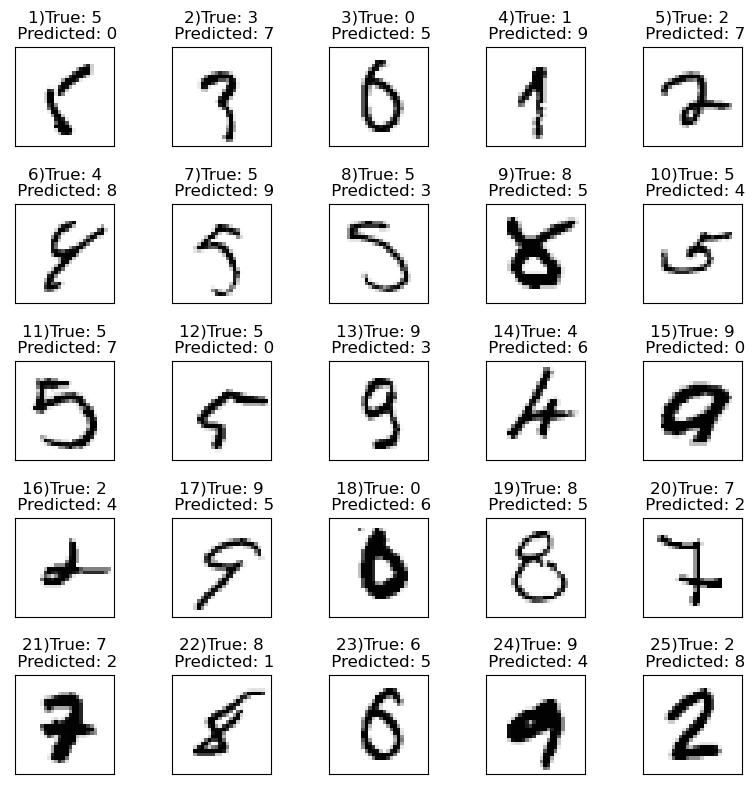

In [40]:
# Looking at samples that the model misclassifies
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(
    nrows=5,
    ncols=5,
    sharex=True,
    sharey=True,
    figsize=(8,8)
)

ax = ax.flatten()

for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1})'
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.savefig('./Results/5_Misclassified_Images.png')
plt.show()